In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F

In [21]:
df=pd.read_csv('houseprice.csv',usecols=["SalePrice", "MSSubClass", "MSZoning", "LotFrontage", "LotArea",
                                         "Street", "YearBuilt", "LotShape", "1stFlrSF", "2ndFlrSF"]).dropna()

In [22]:
df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,YearBuilt,1stFlrSF,2ndFlrSF,SalePrice
0,60,RL,65.0,8450,Pave,Reg,2003,856,854,208500
1,20,RL,80.0,9600,Pave,Reg,1976,1262,0,181500
2,60,RL,68.0,11250,Pave,IR1,2001,920,866,223500
3,70,RL,60.0,9550,Pave,IR1,1915,961,756,140000
4,60,RL,84.0,14260,Pave,IR1,2000,1145,1053,250000


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1201 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MSSubClass   1201 non-null   int64  
 1   MSZoning     1201 non-null   object 
 2   LotFrontage  1201 non-null   float64
 3   LotArea      1201 non-null   int64  
 4   Street       1201 non-null   object 
 5   LotShape     1201 non-null   object 
 6   YearBuilt    1201 non-null   int64  
 7   1stFlrSF     1201 non-null   int64  
 8   2ndFlrSF     1201 non-null   int64  
 9   SalePrice    1201 non-null   int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 103.2+ KB


In [24]:
### Year Built Feature is converted into the difference of years till current year
import datetime
datetime.datetime.now().year
df['Total Years']=datetime.datetime.now().year-df['YearBuilt']
df.drop("YearBuilt",axis=1,inplace=True)
df.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,1stFlrSF,2ndFlrSF,SalePrice,Total Years
0,60,RL,65.0,8450,Pave,Reg,856,854,208500,17
1,20,RL,80.0,9600,Pave,Reg,1262,0,181500,44
2,60,RL,68.0,11250,Pave,IR1,920,866,223500,19
3,70,RL,60.0,9550,Pave,IR1,961,756,140000,105
4,60,RL,84.0,14260,Pave,IR1,1145,1053,250000,20


In [25]:
cat_features=["MSSubClass", "MSZoning", "Street", "LotShape"]
out_feature="SalePrice"

In [27]:
##Label Encoding the Categorical Features
lbl_encoders={}
for feature in cat_features:
    lbl_encoders[feature]=LabelEncoder()
    df[feature]=lbl_encoders[feature].fit_transform(df[feature])


In [32]:
### Stacking categorical features and converting them into tensors
cat_features=np.hstack((df[feature].values.reshape(-1,1) for feature in cat_features))
cat_features

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


array([[5, 3, 1, 3],
       [0, 3, 1, 3],
       [5, 3, 1, 0],
       ...,
       [6, 3, 1, 3],
       [0, 3, 1, 3],
       [0, 3, 1, 3]])

In [34]:
### Converting Numpy array to Torch tensors
cat_features=torch.tensor(cat_features,dtype=torch.int64)
cat_features

tensor([[5, 3, 1, 3],
        [0, 3, 1, 3],
        [5, 3, 1, 0],
        ...,
        [6, 3, 1, 3],
        [0, 3, 1, 3],
        [0, 3, 1, 3]])

In [35]:
### Creating continuos variables
cont_features=[]
for i in df.columns:
    if i in ["MSSubClass", "MSZoning", "Street", "LotShape","SalePrice"]:
        pass
    else:
        cont_features.append(i)


In [36]:
### Stacking continuous variable to a tensor
cont_values=np.stack([df[feature].values for feature in cont_features],axis=1)
cont_values=torch.tensor(cont_values,dtype=torch.float)
cont_values

tensor([[   65.,  8450.,   856.,   854.,    17.],
        [   80.,  9600.,  1262.,     0.,    44.],
        [   68., 11250.,   920.,   866.,    19.],
        ...,
        [   66.,  9042.,  1188.,  1152.,    79.],
        [   68.,  9717.,  1078.,     0.,    70.],
        [   75.,  9937.,  1256.,     0.,    55.]])

In [38]:
### Converting target variable into Torch tensors
y=torch.tensor(df['SalePrice'].values,dtype=torch.float).reshape(-1,1)
y

tensor([[208500.],
        [181500.],
        [223500.],
        ...,
        [266500.],
        [142125.],
        [147500.]])

In [39]:
#### Finding the number of unique values for each categorical feature
cat_dims=[len(df[col].unique()) for col in ["MSSubClass", "MSZoning", "Street", "LotShape"]]
cat_dims

[15, 5, 2, 4]

In [58]:
### Finding the desired embedding dimension using some thumb rules
embedding_dim= [(x, min(50, (x + 1) // 2)) for x in cat_dims]
embedding_dim

[(15, 8), (5, 3), (2, 1), (4, 2)]

In [46]:
embed_representation=nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dim])
embed_representation

ModuleList(
  (0): Embedding(15, 8)
  (1): Embedding(5, 3)
  (2): Embedding(2, 1)
  (3): Embedding(4, 2)
)

In [49]:
### Extracting the embedding in form of tensors
embedding_val=[]
for i,e in enumerate(embed_representation):
    embedding_val.append(e(cat_features[:,i]))
embedding_val


[tensor([[ 0.6479,  0.4738,  0.7491,  ...,  1.3382,  0.5288,  1.1253],
         [-1.6160,  1.8831, -0.9623,  ..., -1.3363, -2.4629,  0.9874],
         [ 0.6479,  0.4738,  0.7491,  ...,  1.3382,  0.5288,  1.1253],
         ...,
         [ 1.4524,  0.5377,  0.5810,  ...,  0.3222, -0.2256,  0.3642],
         [-1.6160,  1.8831, -0.9623,  ..., -1.3363, -2.4629,  0.9874],
         [-1.6160,  1.8831, -0.9623,  ..., -1.3363, -2.4629,  0.9874]],
        grad_fn=<EmbeddingBackward>), tensor([[-0.1309, -1.3461, -1.2227],
         [-0.1309, -1.3461, -1.2227],
         [-0.1309, -1.3461, -1.2227],
         ...,
         [-0.1309, -1.3461, -1.2227],
         [-0.1309, -1.3461, -1.2227],
         [-0.1309, -1.3461, -1.2227]], grad_fn=<EmbeddingBackward>), tensor([[-0.0908],
         [-0.0908],
         [-0.0908],
         ...,
         [-0.0908],
         [-0.0908],
         [-0.0908]], grad_fn=<EmbeddingBackward>), tensor([[ 1.1527, -0.1325],
         [ 1.1527, -0.1325],
         [ 2.1352,  0.4736],

In [51]:
### Concatinating all the embedding for every single record
z=torch.cat(embedding_val,1)
z

tensor([[ 0.6479,  0.4738,  0.7491,  ..., -0.0908,  1.1527, -0.1325],
        [-1.6160,  1.8831, -0.9623,  ..., -0.0908,  1.1527, -0.1325],
        [ 0.6479,  0.4738,  0.7491,  ..., -0.0908,  2.1352,  0.4736],
        ...,
        [ 1.4524,  0.5377,  0.5810,  ..., -0.0908,  1.1527, -0.1325],
        [-1.6160,  1.8831, -0.9623,  ..., -0.0908,  1.1527, -0.1325],
        [-1.6160,  1.8831, -0.9623,  ..., -0.0908,  1.1527, -0.1325]],
       grad_fn=<CatBackward>)

In [52]:
### Applying droput and getting the final embeddings
dropout=nn.Dropout(0.4)
final_embeddings=droput(z)
final_embeddings

tensor([[ 1.0798,  0.0000,  1.2485,  ..., -0.1514,  0.0000, -0.2208],
        [-2.6933,  0.0000, -1.6039,  ..., -0.1514,  1.9211, -0.2208],
        [ 1.0798,  0.0000,  1.2485,  ..., -0.1514,  3.5587,  0.7893],
        ...,
        [ 0.0000,  0.0000,  0.9684,  ..., -0.1514,  0.0000, -0.2208],
        [-2.6933,  3.1385, -0.0000,  ..., -0.1514,  1.9211, -0.0000],
        [-2.6933,  3.1385, -1.6039,  ..., -0.0000,  1.9211, -0.0000]],
       grad_fn=<MulBackward0>)

In [53]:
### Making a class of feedforward neural network using pytorch
class FeedForwardNN(nn.Module):

    def __init__(self, embedding_dim, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dim])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((out for inp,out in embedding_dim))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)

      
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x  

In [54]:
model=FeedForwardNN(embedding_dim,len(cont_features),1,[100,50],p=0.4)

In [55]:
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

In [56]:
batch_size=1200
test_size=int(batch_size*0.15)
train_categorical=cat_features[:batch_size-test_size]
test_categorical=cat_features[batch_size-test_size:batch_size]
train_cont=cont_values[:batch_size-test_size]
test_cont=cont_values[batch_size-test_size:batch_size]
y_train=y[:batch_size-test_size]
y_test=y[batch_size-test_size:batch_size]

In [57]:
epochs=5000
final_losses=[]
for i in range(epochs):
    i=i+1
    y_pred=model(train_categorical,train_cont)
    loss=torch.sqrt(loss_function(y_pred,y_train)) ### RMSE
    final_losses.append(loss)
    if i%10==1:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch number: 1 and the loss : 200496.84375
Epoch number: 11 and the loss : 200493.78125
Epoch number: 21 and the loss : 200489.65625
Epoch number: 31 and the loss : 200483.125
Epoch number: 41 and the loss : 200473.9375
Epoch number: 51 and the loss : 200463.125
Epoch number: 61 and the loss : 200447.578125
Epoch number: 71 and the loss : 200430.09375
Epoch number: 81 and the loss : 200407.984375
Epoch number: 91 and the loss : 200383.890625
Epoch number: 101 and the loss : 200358.0625
Epoch number: 111 and the loss : 200324.25
Epoch number: 121 and the loss : 200291.59375
Epoch number: 131 and the loss : 200252.21875
Epoch number: 141 and the loss : 200207.671875
Epoch number: 151 and the loss : 200161.9375
Epoch number: 161 and the loss : 200118.703125
Epoch number: 171 and the loss : 200057.453125
Epoch number: 181 and the loss : 200008.421875
Epoch number: 191 and the loss : 199943.953125
Epoch number: 201 and the loss : 199879.015625
Epoch number: 211 and the loss : 199821.515625

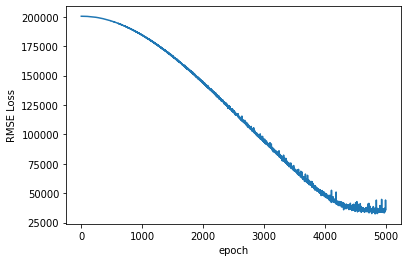

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(range(epochs), final_losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [ ]:
### Thank you!!!